# Time series example using RNN

Predict one forecastand apply recursively

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 


path='/tmp/'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14649758601885771997
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11787596596
locality {
  bus_id: 1
}
incarnation: 8686234281006809372
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:05:00.0"
]


In [4]:
# Generate seasonal data dataframe
n_cases = 365*10

data=[]
for i in range(n_cases):
    t = (i/100.)
    s = abs((i%7)-3.5)*2.
    data += list(t + s + np.random.randn(1))

index = pd.date_range('1/1/2000', periods=n_cases)
serie = pd.Series(data=data, index=index, name='value')
serie.head


<bound method NDFrame.head of 2000-01-01     7.099708
2000-01-02     5.012824
2000-01-03     3.584807
2000-01-04     0.758242
2000-01-05     2.143984
2000-01-06     1.956460
2000-01-07     6.367832
2000-01-08     8.402213
2000-01-09     6.274409
2000-01-10     3.253495
2000-01-11     2.459651
2000-01-12     1.084292
2000-01-13     3.992837
2000-01-14     4.077933
2000-01-15     7.769261
2000-01-16     4.256343
2000-01-17     2.778036
2000-01-18     2.274108
2000-01-19     2.004974
2000-01-20     3.428455
2000-01-21     5.827087
2000-01-22     7.376229
2000-01-23     6.054700
2000-01-24     3.878018
2000-01-25     0.517604
2000-01-26     1.573171
2000-01-27     4.190089
2000-01-28     5.395799
2000-01-29     6.909765
2000-01-30     4.729632
                ...    
2004-11-30    18.865981
2004-12-01    18.751294
2004-12-02    21.988582
2004-12-03    22.795392
2004-12-04    25.212030
2004-12-05    23.839876
2004-12-06    22.244827
2004-12-07    18.985281
2004-12-08    18.513164
2004-12-09

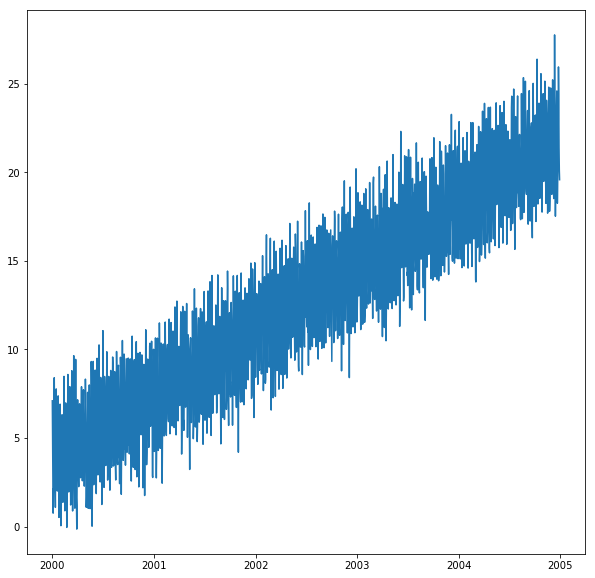

In [5]:
plt.plot(serie)

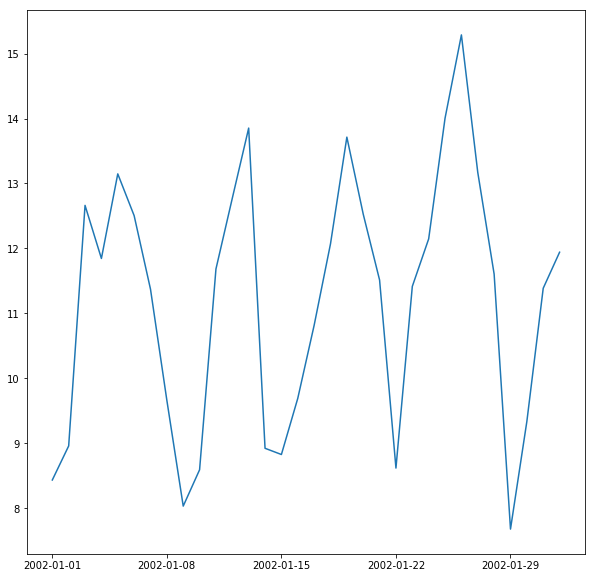

In [6]:
plt.plot(serie['1/1/2002':'2/1/2002'])

In [7]:
def extract_sequences(serie_np, maxlen=14, step=1):
    '''
    Cut the serie in redundant sequences of maxlen data
    One sequence of length 14 for each day
    '''
    sequences = []
    nex_data = []
    for i in range(0, serie_np.shape[0] - maxlen, step): 
        sequences.append(serie_np[i: i + maxlen])
        nex_data.append(serie_np[i + maxlen])
    return np.array(sequences), np.array(nex_data)
#X_trn , y_trn  = extract_sequences(seqs, maxlen=14*24, step=1)

In [8]:
# Extract sequences
n_weeks = 20
maxlen=7*n_weeks

X_trn , y_trn  = extract_sequences(serie.as_matrix()[:n_cases-300], maxlen=maxlen, step=1)
X_tst , y_tst  = extract_sequences(serie.as_matrix()[n_cases-300:], maxlen=maxlen, step=1)
print(X_trn.shape, y_trn.shape)
print(X_tst.shape, y_tst.shape)
print(y_tst[0])




(1385, 140) (1385,)
(160, 140) (160,)
22.4365308247


In [9]:
# Normalize
range_trn = np.max(X_trn) - np.min(X_trn)
print(range_trn)
X_trn = (X_trn / range_trn) -0.5
y_trn = (y_trn / range_trn) -0.5
X_tst = (X_tst / range_trn) -0.5
y_tst = (y_tst / range_trn) -0.5

23.4049256878


In [10]:
def generate_batch(X, y, batch_size=4, limit=-1, shuffle_data=True):
    ''' 
    Generate batches for one epoch
    Randomize order for each epoch
    '''
    shuffle_index = [i for i in range(0, X.shape[0], batch_size)]
    if shuffle_data:
        from random import shuffle
        shuffle(shuffle_index)
    
    for i in shuffle_index[:limit]:
        yield X[i:i+batch_size], y[i:i+batch_size]
        
gb = generate_batch(X_trn, y_trn)

## Basic rnn model over original serie

In [11]:
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [12]:
def dense(x, input_size=10, otput_size=1):
    W = tf.Variable(tf.truncated_normal([input_size, otput_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[otput_size]))
    return tf.matmul(x,W) + b

In [14]:
# Parameters

#features = 1
lstm_feat = 512

#Inputs
x_input = tf.placeholder(tf.float32, shape=[None, maxlen], name='x')
x_input_lstm = tf.reshape(x_input, [-1,maxlen, 1])
y_input = tf.placeholder(tf.float32, shape=[None], name='y')

# Recurrent layer
lstm1 = tf.contrib.rnn.BasicLSTMCell(lstm_feat)
lstm_out, _ = tf.nn.dynamic_rnn(lstm1, x_input_lstm, dtype=tf.float32, scope='lstm04')
print(lstm_out)

#Final dense layer
y_pred  = tf.reshape(dense(lstm_out[:,-1,:], input_size=lstm_feat, otput_size=1),[-1])
print(y_pred)

# Loss function
cost  = tf.reduce_sum(tf.square(y_pred - y_input))

# Trainer
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Tensor("lstm04/transpose:0", shape=(?, 140, 512), dtype=float32)
Tensor("Reshape_2:0", shape=(?,), dtype=float32)


In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
# Train graph
num_epoch=200
batchSize=256

i=0
lr=0.001
for epoch in range(num_epoch):
    c_trn = []
    gb = generate_batch(X_trn, y_trn, batch_size=batchSize)
    for x_b, y_b in gb:
        feed_dict={x_input: x_b, y_input: y_b, learning_rate: lr}
        _, c, prediction, l_out = sess.run([train_step, cost, y_pred, lstm_out], feed_dict=feed_dict)
        c_trn += [c]
    i += 1
    if i%10==0:
        c_tst = cost.eval(feed_dict={x_input: X_tst, y_input: y_tst})   
        print('Epoch: ', epoch, ' - LR: ',lr, ' - Cost: ',np.mean(c_trn, axis=0), ' - Cost test: ',c_tst )
    lr *= 0.99

Epoch:  9  - LR:  0.0009135172474836408  - Cost:  2.23874  - Cost test:  1.49787
Epoch:  19  - LR:  0.0008261686238355864  - Cost:  0.990124  - Cost test:  0.529994
Epoch:  29  - LR:  0.0007471720943315961  - Cost:  0.599396  - Cost test:  0.564354
Epoch:  39  - LR:  0.000675729049060283  - Cost:  0.626233  - Cost test:  0.587032
Epoch:  49  - LR:  0.0006111172395328649  - Cost:  0.5462  - Cost test:  0.37746
Epoch:  59  - LR:  0.000552683477162385  - Cost:  0.53134  - Cost test:  0.370678
Epoch:  69  - LR:  0.0004998370298991989  - Cost:  0.624471  - Cost test:  0.400095
Epoch:  79  - LR:  0.00045204365026647533  - Cost:  0.531358  - Cost test:  0.34791
Epoch:  89  - LR:  0.0004088201744225492  - Cost:  0.572919  - Cost test:  0.47444
Epoch:  99  - LR:  0.00036972963764972643  - Cost:  0.543916  - Cost test:  0.498849
Epoch:  109  - LR:  0.000334376856889913  - Cost:  0.534326  - Cost test:  0.36573
Epoch:  119  - LR:  0.00030240443566902157  - Cost:  0.51296  - Cost test:  0.361151
E

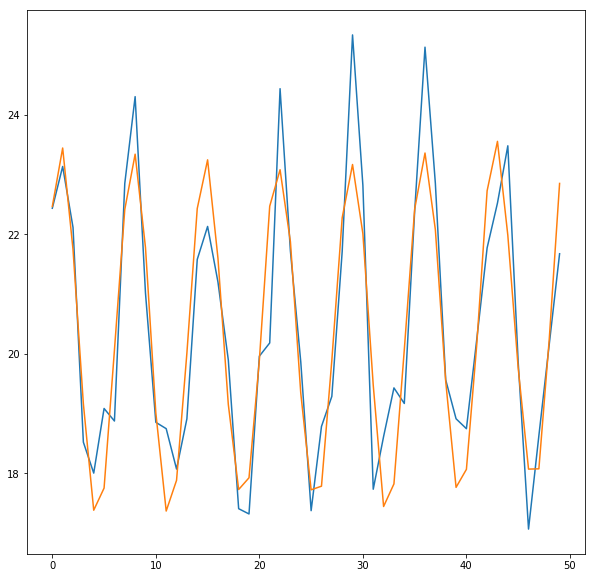

In [17]:
#Score test data
predict_tst = []
real_tst = []
gb_test = generate_batch(X_tst, y_tst, batch_size=X_tst.shape[0]-1 , shuffle_data=False)
for x_b, y_b in gb_test:
    p = y_pred.eval(feed_dict={x_input: x_b})
    predict_tst = np.concatenate((predict_tst, p))
    real_tst = np.concatenate((real_tst, y_b))

# Plot for 1 step forecast
plt.plot((real_tst[:50]+0.5)*range_trn)
plt.plot((predict_tst[:50]+0.5)*range_trn)
plt.show()    

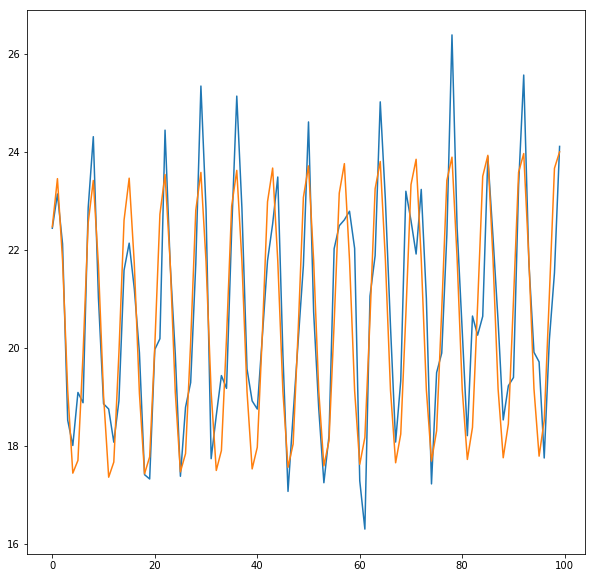

RMSE:  1.1687421554576323


In [18]:
#Recursive aplication of forecast
n_forecast = 100

x = [X_tst[0]]
y = y_tst[0]

y_fore = []
y_real = np.empty([0])
for i in range(n_forecast):
    pred = y_pred.eval(feed_dict={x_input: x})
    y_real = np.concatenate((y_real, np.array([y_tst[i]])))
    y_fore = np.concatenate((y_fore, pred))
    x = [np.concatenate((x[0][1:],pred))]
    

# Plot results
plt.plot((y_real+0.5)*range_trn)
plt.plot((y_fore+0.5)*range_trn)
plt.show()

# RMSE out of sample
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error((y_real+0.5)*range_trn, (y_fore+0.5)*range_trn))
print('RMSE: ', rmse)